In [57]:
import pandas as pd
import io
import requests
import certifi

#from GitHub repository
url = "https://raw.githubusercontent.com/robynhathaway/RPDA-PHC-Project/refs/heads/main/RPDA_Merged_Dataset.csv"
df = pd.read_csv(url)
df.head()


,Province,District,Year,Area_Classification,Population,PHC_Headcount,PHC_Facilities_Total,Med_Pracs_per100k,PHC_Expend_pc,StatsSA_Households_Landline (%),StatsSA_Households_Cellphone (%),StatsSA_Households_LandCell (%),StatsSA_Household_None (%),StatsSA_Households_MobileInt (%),StatsSA_Households_FixInt (%),StatsSA_Households_PubWIFI (%),StatsSA_Households_WorkInt ()%),StatsSA_Households_AnyIntAccess (%),Distance_PHC (km)
0,EC,A Nzo DM: DC44,2022,Rural,1660133,NaN,74,34.3904,1095.837,0.0,88.4,3.5,8.2,63.6,6.6,4.2,9.8,66.9,0.91
1,EC,A Nzo DM: DC44,2023,Rural,1662224,NaN,74,38.8066,1077.148,0.1,90.2,2.3,7.4,67.2,7.7,5.6,9.8,70.2,0.91
2,EC,A Nzo DM: DC44,2024,Rural,832500,1485616.0,76,34.7234,1161.001,0.1,91.3,1.4,7.3,68.0,8.0,1.7,8.6,70.7,0.91
3,EC,Amathole DM: DC12,2022,Rural,1574834,NaN,148,34.3904,1095.837,0.0,88.4,3.5,8.2,63.6,6.6,4.2,9.8,66.9,0.24
4,EC,Amathole DM: DC12,2023,Rural,1557768,NaN,148,38.8066,1077.148,0.1,90.2,2.3,7.4,67.2,7.7,5.6,9.8,70.2,0.24


In [50]:
#key columns
POP   = "Population"
PRACS = "Med_Pracs_per100k"
FACS  = "PHC_Facilities_Total"
YEAR  = "Year"
PROV  = "Province"
DISTRICT = "District"
AREA  = "Area_Classification"
DIST = "Distance_PHC (km)"
ANYINT = "StatsSA_Households_AnyIntAccess (%)"

In [51]:
# function to convert % columns to proportion in [0,1]

def to_prop(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.extract(r"([-+]?\d*\.?\d+)", expand=False).astype(float)
    # if values look like 0..100, convert to 0..1
    if s.dropna().max() is not None and s.dropna().max() > 1.5:
        s = s / 100.0
    return s


In [52]:
import numpy as np 
#Create Features

df["log_pop"] = np.log1p(pd.to_numeric(df[POP], errors="coerce"))

#Digital Readiness
df["AnyInt_prop"] = to_prop(df[ANYINT]) 

#estimated number of practitioners
df["Est_Pracs_Total"] = (df[PRACS] * df[POP]) / 100_000.0

In [53]:
# using only 2024 PHC_Headcount so make a copy

train_2024 = df[df[YEAR] == 2024].copy()

# make sure there all 2024 records are not null for training
target_col = "PHC_Headcount"
train_2024 = train_2024[~train_2024[target_col].isna()].copy()
print("Training rows (2024 with observed headcount):", len(train_2024))

Training rows (2024 with observed headcount): 52


Poisson (2024 fit)  →  RMSE=190,586  MAE=147,333  R²=0.986  sMAPE=8.37%  MdAPE=7.74%


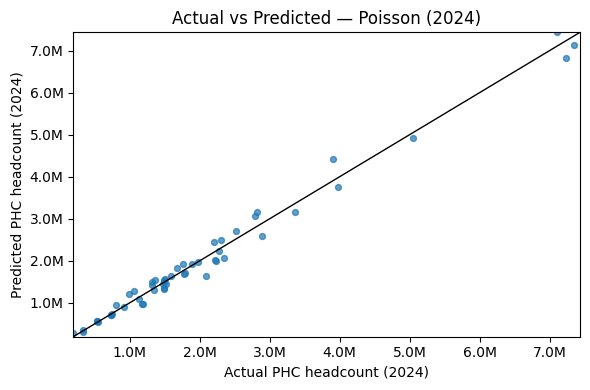

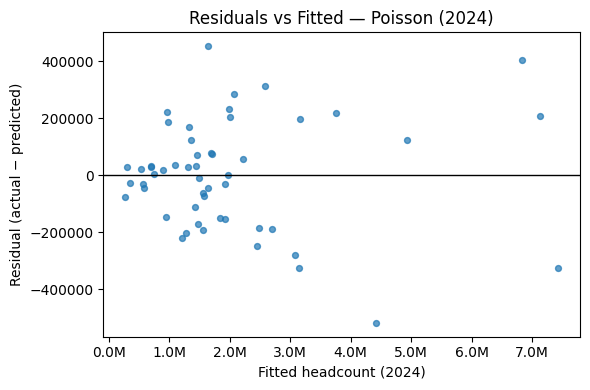

In [54]:
# Features
num_cols = ["log_pop", PRACS, FACS, "AnyInt_prop", DIST]
cat_cols = [AREA, PROV]

X_train = train_2024[num_cols + cat_cols]
y_train = train_2024[target_col]

#pre-process
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
pre_process = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)


#Poisson model

from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

YEAR   = "Year"
TARGET = "PHC_Headcount"

# fit Poisson on 2024 (observed headcount only)

poisson = Pipeline([("pre", pre_process), ("mdl", PoissonRegressor(alpha=1e-6, max_iter=1000))])
poisson.fit(X_train, y_train)
y_pred_2024 = poisson.predict(X_train)

# metrics
def smape(y, yhat):
    return 100 * np.mean(2*np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + 1e-9))

mdape = np.nanmedian(np.abs((y_train - y_pred_2024) / np.where(y_train==0, np.nan, y_train))) * 100
rmse  = np.sqrt(mean_squared_error(y_train, y_pred_2024))
mae   = mean_absolute_error(y_train, y_pred_2024)
r2    = r2_score(y_train, y_pred_2024)

print(f"Poisson (2024 fit)  →  RMSE={rmse:,.0f}  MAE={mae:,.0f}  R²={r2:.3f}  sMAPE={smape(y_train, y_pred_2024):.2f}%  MdAPE={mdape:.2f}%")

# plots
fmt_millions = FuncFormatter(lambda x, pos: f"{x/1e6:.1f}M")

# Actual vs Predicted with 45° line
plt.figure(figsize=(6,4))
plt.scatter(y_train, y_pred_2024, s=18, alpha=0.7)
lims = [min(y_train.min(), y_pred_2024.min()), max(y_train.max(), y_pred_2024.max())]
plt.plot(lims, lims, color="black", linewidth=1)
ax = plt.gca()
ax.xaxis.set_major_formatter(fmt_millions)
ax.yaxis.set_major_formatter(fmt_millions)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual PHC headcount (2024)")
plt.ylabel("Predicted PHC headcount (2024)")
plt.title("Actual vs Predicted — Poisson (2024)")
plt.tight_layout(); plt.show()

# Residuals vs Fitted
resid = y_train - y_pred_2024
plt.figure(figsize=(6,4))
plt.scatter(y_pred_2024, resid, s=18, alpha=0.7)
plt.axhline(0, color="black", linewidth=1)
ax = plt.gca()
ax.xaxis.set_major_formatter(fmt_millions)
plt.xlabel("Fitted headcount (2024)")
plt.ylabel("Residual (actual − predicted)")
plt.title("Residuals vs Fitted — Poisson (2024)")
plt.tight_layout(); plt.show()



In [55]:
#predict on all year 2022-2024

if "log_pop" not in df.columns:
    df["log_pop"] = np.log1p(pd.to_numeric(df[POP], errors="coerce"))

if "AnyInt_prop" not in df.columns:
    def to_prop(s):
        s = s.astype(str).str.extract(r"([\-+]?\d+\.?\d*)", expand=False).astype(float)
        if s.dropna().size and s.dropna().max() > 1.5:  # convert 0..100 to 0..1
            s = s / 100.0
        return s
    df["AnyInt_prop"] = to_prop(df[ANYINT])
    num_cols = ["log_pop", PRACS, FACS, "AnyInt_prop", DIST]
cat_cols = [AREA, PROV]
X_all = df.loc[:, num_cols + cat_cols].copy()
df["PHC_Headcount_Pred"] = poisson.predict(X_all)
# df.head()

In [56]:

# combine observed 2024 values with imputed 2022–2023
df["PHC_Headcount_Final"] = np.where(df[YEAR] == 2024,
                                     df["PHC_Headcount"],
                                     df["PHC_Headcount_Pred"])

# renamed for consistency with report
df["PHC_Headcount"] = df["PHC_Headcount_Final"]

# Export to CSV
# df.to_csv("PHC_Project_Dataset.csv", index=False)
